# How-to Guide: Setting Environment Variables

This guide explains how to use `EnvVarRequirement` to set environment variables in a CWL workflow. 

We will focus on the `EnvVarRequirement` block and its usage in the example provided.

## Objective

Set specific environment variables for a command-line tool in CWL to configure its behavior dynamically.

Relevant Block:

In [2]:
cwl_file="../cwl/04-env/environment-variable.cwl"

cat  $cwl_file | yq e .'$graph[2]' - | yq '.. | select(has("EnvVarRequirement")) | {"EnvVarRequirement": .EnvVarRequirement}'

EnvVarRequirement:
  envDef:
    GDAL_TIFF_INTERNAL_MASK: YES
    GDAL_HTTP_MERGE_CONSECUTIVE_RANGES: YES
    CPL_VSIL_CURL_ALLOWED_EXTENSIONS: ".tif"




This configuration:

* `GDAL_TIFF_INTERNAL_MASK`: Enables internal masking for TIFF files.
* `GDAL_HTTP_MERGE_CONSECUTIVE_RANGES`: Optimizes HTTP range requests.
* `CPL_VSIL_CURL_ALLOWED_EXTENSIONS`: Restricts allowed file extensions to `.tif`.


## Steps

1. Understand the CWL Workflow Structure

The workflow (`environment-variable.cwl`) processes a Sentinel-2 STAC item to:

* Fetch band URLs: The `stac` tool retrieves asset URLs for specified bands.
* Stack TIFFs: The `rio_stack` tool stacks these bands into a single file.
* Apply color correction: The `rio_color` tool processes the stacked file to create an RGB TIFF.



2. Define the Environment Variables

The `EnvVarRequirement` is applied in the `rio_stack` tool:

Relevant Block

In [3]:
cat  $cwl_file | yq e .'$graph[2]' -

class: CommandLineTool
id: rio_stack
requirements:
  DockerRequirement:
    dockerPull: ghcr.io/eoap/how-to/how-to-container:1.1.0
  EnvVarRequirement:
    envDef:
      GDAL_TIFF_INTERNAL_MASK: YES
      GDAL_HTTP_MERGE_CONSECUTIVE_RANGES: YES
      CPL_VSIL_CURL_ALLOWED_EXTENSIONS: ".tif"
baseCommand: rio
arguments:
  - stack
  - valueFrom: "${  \n  var arr = [];\n  for(var i=0; i<inputs.tiffs.length; i++) {\n      arr.push(inputs.tiffs[i]); \n  }\n  return arr; \n  }\n"
  - stacked.tif
inputs:
  tiffs:
    type: string[]
outputs:
  stacked:
    type: File
    outputBinding:
      glob: stacked.tif


Key Elements

1. `EnvVarRequirement`: Specifies environment variables.
  * `envDef`: Key-value pairs of environment variables.

2. Variables Defined:

* `GDAL_TIFF_INTERNAL_MASK`: Enables internal TIFF masks.
* `GDAL_HTTP_MERGE_CONSECUTIVE_RANGES`: Ensures efficient HTTP range fetching.
* `CPL_VSIL_CURL_ALLOWED_EXTENSIONS`: Restricts file access to `.tif`.


3. Workflow Overview

The workflow orchestrates the process with three steps:

* **Step 1: Fetch Band URLs**

The stac tool fetches asset URLs for the specified bands.

* **Step 2: Stack TIFF Files**

The `rio_stack` tool stacks the band TIFFs into a single file (stacked.tif) using the environment variables defined in `EnvVarRequirement`.

* **Step 3: Apply Color Correction**

The `rio_color` tool applies color correction and generates an RGB TIFF (rgb.tif).



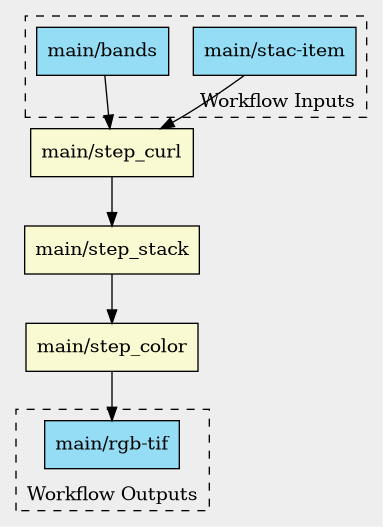

In [4]:
cwltool --print-dot $cwl_file 2> /dev/null | dot -Tpng | display

4. Run the Workflow

Use the following command to execute the workflow:

```bash
cwltool environment-variable.cwl \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
    --bands red \
    --bands green \
    --bands blue 
```

In [5]:
cwltool $cwl_file \
    --stac-item https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A \
    --bands red \
    --bands green \
    --bands blue > output.json

INFO /home/fbrito/.local/bin/cwltool 3.1.20240508115724
INFO Resolved '../cwl/04-env/environment-variable.cwl' to 'file:///data/work/github/eoepca-plus/how-to/cwl/04-env/environment-variable.cwl'
INFO [workflow ] start
INFO [workflow ] starting step step_curl
INFO [step step_curl] start
INFO [job step_curl] /tmp/b_nlb56z$ docker \
    run \
    -i \
    --mount=type=bind,source=/tmp/b_nlb56z,target=/BIeMWV \
    --mount=type=bind,source=/tmp/7bkv7zq_,target=/tmp \
    --workdir=/BIeMWV \
    --read-only=true \
    --log-driver=none \
    --user=1000:1000 \
    --rm \
    --cidfile=/tmp/05v10i1c/20241229174437-581493.cid \
    --env=TMPDIR=/tmp \
    --env=HOME=/BIeMWV \
    docker.io/curlimages/curl:latest \
    curl \
    https://earth-search.aws.element84.com/v0/collections/sentinel-s2-l2a-cogs/items/S2B_53HPA_20210723_0_L2A > /tmp/b_nlb56z/message
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   

5. Expected Output

The workflow processes the STAC item and generates:

* Final Output (`rgb.tif`): The RGB TIFF file with color correction applied.

In [7]:
cat output.json | jq -e . -

{
  "rgb-tif": {
    "location": "file:///data/work/github/eoepca-plus/how-to/docs/rgb.tif",
    "basename": "rgb.tif",
    "class": "File",
    "checksum": "sha1$84067d0d942d5b100b67f21e0e38cc4650fe900f",
    "size": 361747464,
    "path": "/data/work/github/eoepca-plus/how-to/docs/rgb.tif"
  }
}


## Key Takeaways

1. Setting Environment Variables:

* Use `EnvVarRequirement` to configure the runtime environment for a tool.
* Define key-value pairs in the `envDef` field.

2. Optimizing with Environment Variables:

* `GDAL_TIFF_INTERNAL_MASK`: Improves TIFF file processing.
* `GDAL_HTTP_MERGE_CONSECUTIVE_RANGES`: Reduces HTTP overhead.
* `CPL_VSIL_CURL_ALLOWED_EXTENSIONS`: Ensures only `.tif` files are accessed.

By focusing on the `EnvVarRequirement` block, you can customize tool behavior to meet specific requirements in your CWL workflows.